In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import os

In [7]:
# Download latest version
current_dir = os.getcwd()
path = kagglehub.dataset_download("irkaal/foodcom-recipes-and-reviews")

print("Path to dataset files:", path)

100%|██████████| 723M/723M [01:06<00:00, 11.5MB/s] 

Extracting files...


Path to dataset files: C:\Users\spadr\.cache\kagglehub\datasets\irkaal\foodcom-recipes-and-reviews\versions\2


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
dfRec = pd.read_csv('..\\data\\recipes.csv')
dfRev = pd.read_csv('..\\data\\reviews.csv')

In [ ]:
dfRev.head(25)
# print(dfRev['Review'].head(10).tolist())

In [ ]:
print(dfRev['Review'].head(25).tolist())

In [ ]:
dfRec.head(10)

In [ ]:
# print(dfRec['Images'].head(10).tolist())
print(dfRec[dfRec['RecipeId'] == 992])

# Data Exploration

## Recipe Dataset

In [ ]:
dfRec.info()
dfRec.describe()

In [ ]:
recipe_category_counts = dfRec['RecipeCategory'].value_counts()
top_10_counts = recipe_category_counts.head(25) # Select only the top 25 categories
other_count = recipe_category_counts.iloc[25:].sum()
top_10_with_other = pd.concat([top_10_counts, pd.Series({'Other':other_count})])

plt.figure(figsize=(10, 6))
plt.pie(top_10_with_other, labels=top_10_with_other.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Recipe Categories')
plt.show()

### Data Cleaning

In [4]:
dfRec.drop(columns=['Images', 'RecipeYield','AuthorName'], inplace=True)

# Deal with null values:
dfRec['CookTime'].fillna(0, inplace=True) # NaN means no cooking required
dfRec['ReviewCount'].fillna(0, inplace=True) # NaN means no reviews
dfRec['AggregatedRating'].fillna(2.5, inplace=True) # Use a neutral value even though median is 5.0 and mean 4.6 since we have no indication of quality
dfRec['RecipeServings'].fillna(dfRec['RecipeServings'].median(), inplace=True)
dfRec['Description'].fillna('', inplace=True) # Put empty description
dfRec['RecipeCategory'].fillna(dfRec['Name'], inplace=True) # Substitute category with recipe name
dfRec['Keywords'].fillna(dfRec['RecipeIngredientParts'], inplace=True) # Substitute with ingredients, any better ideas?
dfRec['RecipeIngredientQuantities'].fillna('c("0")',inplace=True) # There are only 3 missing

dfRec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   CookTime                    522517 non-null  object 
 4   PrepTime                    522517 non-null  object 
 5   TotalTime                   522517 non-null  object 
 6   DatePublished               522517 non-null  object 
 7   Description                 522517 non-null  object 
 8   RecipeCategory              522517 non-null  object 
 9   Keywords                    522517 non-null  object 
 10  RecipeIngredientQuantities  522517 non-null  object 
 11  RecipeIngredientParts       522517 non-null  object 
 12  AggregatedRating            522517 non-null  float64
 13  ReviewCount   

In [5]:
dfRec.describe()

,RecipeId,AuthorId,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings
count,522517.000000,5.225170e+05,522517.000000,522517.000000,522517.000000,522517.000000,522517.000000,522517.000000,5.225170e+05,522517.000000,522517.000000,522517.000000,522517.000000,522517.000000
mean,271821.436970,4.572585e+07,3.598794,2.751656,484.438580,24.614922,9.559457,86.487003,7.672639e+02,49.089092,3.843242,21.878254,17.469510,7.693874
std,155495.878422,2.929714e+08,1.160894,15.015307,1397.116649,111.485798,46.622621,301.987009,4.203621e+03,180.822062,8.603163,142.620191,40.128837,92.171835
min,38.000000,2.700000e+01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,137206.000000,6.947400e+04,2.500000,0.000000,174.200000,5.600000,1.500000,3.800000,1.233000e+02,12.800000,0.800000,2.500000,3.500000,4.000000
50%,271758.000000,2.389370e+05,3.000000,1.000000,317.100000,13.800000,4.700000,42.600000,3.533000e+02,28.200000,2.200000,6.400000,9.100000,6.000000
75%,406145.000000,5.658280e+05,5.000000,2.000000,529.100000,27.400000,10.800000,107.900000,7.922000e+02,51.100000,4.600000,17.900000,25.000000,6.000000
max,541383.000000,2.002886e+09,5.000000,3063.000000,612854.600000,64368.100000,26740.600000,130456.400000,1.246921e+06,108294.600000,3012.000000,90682.300000,18396.200000,32767.000000


### Dataset Splitting and Scaling

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

num_feature_columns = [
    'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent',
    'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
    'CarbohydrateContent', 'FiberContent', 'SugarContent',
    'ProteinContent', 'RecipeServings'
]

train_recipe_data, test_recipe_data = train_test_split(dfRec, test_size=0.2, random_state=42)
recipe_scaler = StandardScaler()

train_recipe_data[num_feature_columns] = recipe_scaler.fit_transform(train_recipe_data[num_feature_columns])
test_recipe_data[num_feature_columns] = recipe_scaler.transform(test_recipe_data[num_feature_columns]) # Use fit from trainig data to prevent data leakage

## Review Dataset

In [7]:
dfRev.info()
dfRev.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   ReviewId       1401982 non-null  int64 
 1   RecipeId       1401982 non-null  int64 
 2   AuthorId       1401982 non-null  int64 
 3   AuthorName     1401982 non-null  object
 4   Rating         1401982 non-null  int64 
 5   Review         1401768 non-null  object
 6   DateSubmitted  1401982 non-null  object
 7   DateModified   1401982 non-null  object
dtypes: int64(4), object(4)
memory usage: 85.6+ MB


,ReviewId,RecipeId,AuthorId,Rating
count,1.401982e+06,1.401982e+06,1.401982e+06,1.401982e+06
mean,8.179739e+05,1.526412e+05,1.558638e+08,4.407951e+00
std,5.280821e+05,1.301112e+05,5.305111e+08,1.272012e+00
min,2.000000e+00,3.800000e+01,1.533000e+03,0.000000e+00
25%,3.743862e+05,4.703875e+04,1.336800e+05,4.000000e+00
50%,7.717805e+05,1.093270e+05,3.305450e+05,5.000000e+00
75%,1.204126e+06,2.318768e+05,8.183590e+05,5.000000e+00
max,2.090347e+06,5.412980e+05,2.002902e+09,5.000000e+00


### Data Cleaning

In [ ]:
dfRev['Review'].fillna('', inplace=True) # Put empty description for now
dfRev.drop(columns=['DateSubmitted', 'AuthorName'], inplace=True) # Only keep DateModified
dfRev['DateModified'] = pd.to_datetime(dfRev['DateModified'])
dfRev['year'] = dfRev['DateModified'].dt.year
dfRev['month'] = dfRev['DateModified'].dt.month
dfRev['month_sin'] = np.sin(2 * np.pi * dfRev['month'] / 12) # cyclic enconding for month (so Dec and Jan are close to one another)
dfRev['month_cos'] = np.cos(2 * np.pi * dfRev['month'] / 12)
dfRev.drop(columns=['DateModified', 'month'], inplace=True)

In [11]:
dfRev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   ReviewId      1401982 non-null  int64 
 1   RecipeId      1401982 non-null  int64 
 2   AuthorId      1401982 non-null  int64 
 3   Rating        1401982 non-null  int64 
 4   Review        1401982 non-null  object
 5   DateModified  1401982 non-null  object
dtypes: int64(4), object(2)
memory usage: 64.2+ MB


<Axes: ylabel='Frequency'>

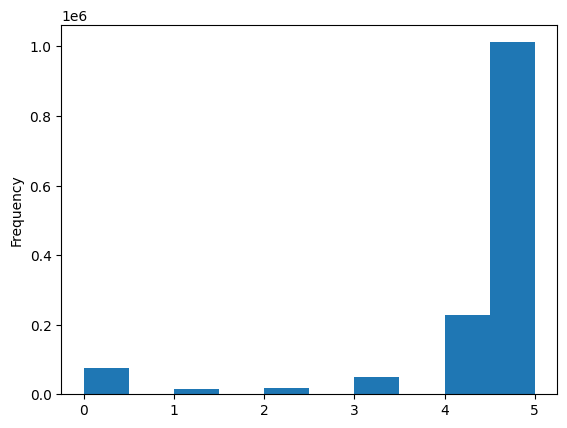

In [9]:
dfRev['Rating'].plot(kind='hist')

In [7]:
train_review_data, test_review_data = train_test_split(dfRev, test_size=0.2, random_state=42)
review_scaler = StandardScaler() # tried QuantileTransformer and PowerTransformer but the data is still very skewed


train_review_data['Rating'] = review_scaler.fit_transform(train_review_data['Rating'].values.reshape(-1, 1))
test_review_data['Rating'] = review_scaler.transform(test_review_data['Rating'].values.reshape(-1, 1)) # Use fit from trainig data to prevent data leakage

# User and Recipe Embeddings

In [8]:
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

batch_size = 1000
reviews = train_review_data['Review'].tolist()

all_embeddings = []

for i in tqdm(range(0, len(reviews), batch_size), desc="Encoding reviews"):
    batch = reviews[i:i+batch_size]
    batch_embeddings = model.encode(batch)
    all_embeddings.append(batch_embeddings)

review_embeddings = np.vstack(all_embeddings)
print(review_embeddings.shape)

KeyboardInterrupt: 

In [39]:
train_review_data.head()

,ReviewId,RecipeId,AuthorId,Rating,Review,DateModified
1369526,2055003,107786,2001757945,0.465609,My first time making spare ribs for the family...,2018-05-29T03:29:40Z
145399,155996,13680,88099,-0.320427,My daughter and I really enjoyed this with our...,2005-02-24T18:00:09Z
498190,540194,2189,685371,0.465609,This recipe is great! It was simple to make an...,2007-12-24T08:34:26Z
96618,104617,89186,141139,0.465609,Uber-yummy. thanks so much for passing the re...,2004-05-24T23:31:56Z
1199756,1377986,497871,178427,0.465609,Terrific! This is one sauce I will be making o...,2013-04-03T20:58:09Z


## Load Feature Group from Hopsworks

In [2]:
import hopsworks 
project = hopsworks.login()
fs = project.get_feature_store(name='recipe_recommender_featurestore')
fg = fs.get_feature_group('reviews', version=1)

2024-12-04 17:35:29,848 INFO: Initializing external client
2024-12-04 17:35:29,849 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-04 17:35:31,262 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1193139


In [3]:
train_review_data = fg.read()

# Display the DataFrame
print(train_review_data.head())

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.16s) 
   reviewid  recipeid  authorid    rating  \
0    733852     18888    170525  0.465609   
1   1508059    257934   2324548 -1.892497   
2    779546    179011    101053  0.465609   
3   1247824    437198    223854  0.465609   
4   1255578    312799   2022859  0.465609   

                                              review  year  month_sin  \
0  [-0.090310626, 0.0057918075, 0.022631085, 0.04...  2008  -0.866025   
1  [0.033940803, -0.014454637, -0.026434703, -0.0...  2016  -0.866025   
2  [-0.06418978, -0.013228689, -0.07730314, -0.01...  2009   0.500000   
3  [-0.018176978, -0.061546214, -0.007779695, 0.0...  2011  -1.000000   
4  [-0.11478278, 0.001350501, 0.008474978, 0.0441...  2011  -0.866025   

      month_cos  
0  5.000000e-01  
1 -5.000000e-01  
2  8.660254e-01  
3 -1.836970e-16  
4  5.000000e-01  


In [13]:
train_review_data['Review'] = list(review_embeddings)
train_review_data.head()

NameError: name 'review_embeddings' is not defined

In [44]:
train_review_data.head()

,ReviewId,RecipeId,AuthorId,Rating,Review,year,month_sin,month_cos
1369526,2055003,107786,2001757945,0.465609,"[0.037868436, 0.02169174, -0.011475431, -0.004...",2018,5.000000e-01,-0.866025
145399,155996,13680,88099,-0.320427,"[-0.018034594, -0.02860534, -0.032772142, 0.04...",2005,8.660254e-01,0.500000
498190,540194,2189,685371,0.465609,"[-0.06688794, -0.06380604, -0.007883271, 0.010...",2007,-2.449294e-16,1.000000
96618,104617,89186,141139,0.465609,"[-0.03430109, -0.012518336, 0.022372436, -0.02...",2004,5.000000e-01,-0.866025
1199756,1377986,497871,178427,0.465609,"[-0.10111904, -0.088520795, -0.02396931, 0.020...",2013,8.660254e-01,-0.500000


## Make Hopsworks Feature Group

In [30]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

2024-12-04 15:34:18,649 INFO: Initializing external client
2024-12-04 15:34:18,653 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-04 15:34:22,063 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1193139


In [34]:
# Get or create the 'Reviews' feature group
reviews_fg = fs.get_or_create_feature_group(
    name="reviews",
    version=1,
    description="Reviews for recipe recommender system.",
    primary_key=['reviewid']
)

In [32]:
print(train_review_data.shape)

(1121585, 8)


In [35]:
# Insert data into feature group
reviews_fg.insert(train_review_data.head(100))

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1193139/fs/1181782/fg/1377751


Uploading Dataframe: 100.00% |██████████| Rows 100/100 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: reviews_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1193139/jobs/named/reviews_1_offline_fg_materialization/executions


(Job('reviews_1_offline_fg_materialization', 'SPARK'), None)

In [ ]:
feature_descriptions = [
    {"name": "reviewid", "description": "Unique identifier for each review"},
    {"name": "recipeid", "description": "Identifier for the recipe being reviewed"},
    {"name": "authorid", "description": "Identifier for the author of the review"},
    {"name": "rating", "description": "Rating given by the author to the recipe (usually 1-5)"},
    {"name": "review", "description": "Numerical representation of the review text (embedding vector from SentenceTransformer)"},
    {"name": "year", "description": "Year when the review was last modified"}
    {"name": "month_sin", "description": "Year when the review was last modified"}
    {"name": "month_cos", "description": "Year when the review was last modified"}
]

for desc in feature_descriptions: 
    reviews_fg.update_feature_description(desc["name"], desc["description"])

# Model Implementation

## Review Tower (Query)

In [8]:
import torch
from torch.utils.data import Dataset

class ReviewsDataset(Dataset):
    def __init__(self, reviews_df):
        """
        Args:
            reviews_df (pd.DataFrame): Dataframe containing the reviews data.
        """
        self.reviews_df = reviews_df

    def __len__(self):
        # Return the total number of samples
        return len(self.reviews_df)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to fetch.
        Returns:
            A dictionary with tensors for the input features and target rating.
        """
        row = self.reviews_df.iloc[idx]
        
        # Extract features
        review_id = row["reviewid"]
        recipe_id = row["recipeid"]
        author_id = row["authorid"]
        review_vector = torch.tensor(row["review"], dtype=torch.float32)  # Convert list to tensor
        year = torch.tensor(row["year"], dtype=torch.float32)
        month_sin = torch.tensor(row["month_sin"], dtype=torch.float32)
        month_cos = torch.tensor(row["month_cos"], dtype=torch.float32)
        # Rating (target)
        rating = torch.tensor(row["rating"], dtype=torch.float32)
        # concat_features = torch.cat(review_vector, month_sin, month_cos)
        # print(concat_features.shape)
        return {
            "review_id": review_id,
            "recipe_id": recipe_id,
            "author_id": author_id,
            "review_vector": review_vector,
            "year": year,
            "month_sin": month_sin,
            "month_cos": month_cos,
            "rating": rating
        }

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ReviewTower(nn.Module):
    def __init__(self, review_vector_dim, embedding_dim):
        """
        Args:
            review_vector_dim (int): Dimensionality of the review feature vector.
            embedding_dim (int): Dimensionality of the output embedding vector.
        """
        super(ReviewTower, self).__init__()
        self.fc1 = nn.Linear(review_vector_dim + 2 + 1 + 1, 128)  # Add month_sin, month_cos, and year, and rating
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, embedding_dim)  # Final embedding layer

    def forward(self, review_vector, month_sin, month_cos, year, rating):
        """
        Forward pass for the review tower.
        
        Args:
            review_vector (Tensor): Review feature vector (e.g., sentence embedding).
            month_sin (Tensor): Sinusoidal month feature.
            month_cos (Tensor): Cosine month feature.
            year (Tensor): Year feature.
            rating (Tensor): Rating given to recipe
        
        Returns:
            Tensor: Embedded vector for the review.
        """
        # Concatenate all features
        x = torch.cat((review_vector, month_sin.unsqueeze(1), month_cos.unsqueeze(1), year.unsqueeze(1), rating.unsqueeze(1)), dim=1)
        
        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Final embedding vector
        return x


In [18]:
from torch.utils.data import DataLoader

# Create the dataset
reviews_dataset = ReviewsDataset(train_review_data)

# Define dimensions
review_vector_dim = len(train_review_data.iloc[0]["review"])  # Dimensionality of the "review" feature
embedding_dim = 32  # Size of the output embedding vector (arbitrary, tunable)

# Initialize the model
review_tower = ReviewTower(review_vector_dim=review_vector_dim, embedding_dim=embedding_dim)

# Create a DataLoader for batching
batch_size = 32
reviews_dataloader = DataLoader(reviews_dataset, batch_size=batch_size, shuffle=True)

# Example: Iterate through the DataLoader
for batch in reviews_dataloader:
    review_embeddings = review_tower(batch["review_vector"], batch["month_sin"], batch["month_cos"], batch["year"], batch["rating"])
    print("Embedding shape:", review_embeddings.shape)
    print(review_embeddings)
    break


Embedding shape: torch.Size([32, 32])
tensor([[-16.8536,  -1.7923, -20.9973,  ...,   3.8912,  10.0015,  -5.3079],
        [-16.8364,  -1.7911, -20.9835,  ...,   3.8780,  10.0000,  -5.3049],
        [-16.8000,  -1.7892, -20.8927,  ...,   3.8727,   9.9704,  -5.2784],
        ...,
        [-16.8512,  -1.7773, -20.9771,  ...,   3.9032,   9.9881,  -5.2955],
        [-16.8726,  -1.7950, -20.9874,  ...,   3.9013,  10.0037,  -5.2934],
        [-16.8804,  -1.7952, -20.9999,  ...,   3.8994,  10.0272,  -5.3012]],
       grad_fn=<AddmmBackward0>)


## Two-Tower Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TwoTowerRecommendationSystem(nn.Module):
    def __init__(self,
                 recipe_vocab_sizes, review_vocab_sizes,
                 embedding_dim, numerical_dims):
        super(TwoTowerRecommendationSystem, self).__init__()

        # Embeddings for Recipe Tower
        self.recipe_embeddings = nn.ModuleDict({
            key: nn.Embedding(vocab_size, embedding_dim)
            for key, vocab_size in recipe_vocab_sizes.items()
        })

        # Embeddings for Review Tower
        self.review_embeddings = nn.ModuleDict({
            key: nn.Embedding(vocab_size, embedding_dim)
            for key, vocab_size in review_vocab_sizes.items()
        })

        # Recipe Tower Network
        recipe_input_dim = len(recipe_vocab_sizes) * embedding_dim + numerical_dims['recipe']
        self.recipe_fc = nn.Sequential(
            nn.Linear(recipe_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

        # Review Tower Network
        review_input_dim = len(review_vocab_sizes) * embedding_dim + numerical_dims['review']
        self.review_fc = nn.Sequential(
            nn.Linear(review_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

    def forward(self, recipe_inputs, review_inputs):
        # Recipe Tower
        recipe_embeds = [
            self.recipe_embeddings[key](value)
            for key, value in recipe_inputs['categorical'].items()
        ]
        recipe_embeds = torch.cat(recipe_embeds, dim=-1)
        recipe_combined = torch.cat([recipe_embeds, recipe_inputs['numerical']], dim=-1)
        recipe_output = self.recipe_fc(recipe_combined)

        # Review Tower
        review_embeds = [
            self.review_embeddings[key](value)
            for key, value in review_inputs['categorical'].items()
        ]
        review_embeds = torch.cat(review_embeds, dim=-1)
        review_combined = torch.cat([review_embeds, review_inputs['numerical']], dim=-1)
        review_output = self.review_fc(review_combined)

        # Calculate similarity (dot product or cosine similarity)
        similarity = F.cosine_similarity(recipe_output, review_output, dim=-1)

        return similarity

# Training